# Trabajo Final: Autoencoder Convolucional

Implementá una red neuronal convolucional auto-encoder para aprender la función identidad con la
base de datos MNIST de dígitos escritos a mano y digitalizados. La red debe tener 784 unidades de
entrada y una red de salida de otras 784 neuronas. Definí la arquitectura que creas adecuada, usá el
algoritmo de descenso por el gradiente más conveniente según tu bien entender. Recordá que la base
MNIST tiene 60000 imágenes en el conjunto de entrenamiento y 10000 imágenes en el conjunto de test.

Compará con los mejores resultados obtenidos en el práctico 3 y comentá.

In [1]:
from ctypes import cdll
lib = cdll.LoadLibrary('/usr/local/cuda-11.2/lib64/libcublas.so.11')


In [76]:

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import keras
from keras import layers
from keras.datasets import mnist
from keras.models import Sequential
import time

import numpy as np

Esta vez vamos a utilizar una arquitectura diferente en el input: Ya no vamos a transformar nuestro dataset a vectores de tamaño 784, si no que vamos a usar la entrada tal cual la recibimos: Una matriz 28 x 28 (con una capa) con una dimensión extra de 1, para tener entradas de la forma 28 x 28 x 1.

In [78]:
input_digit = layers.Input(shape=(28, 28, 1))

# Para crear capas de convolución en 2 dimensiones, usamos el objeto layers.Conv2D, con
# documentación en https://keras.io/api/layers/convolution_layers/convolution2d/

# Vamos a elegir utilizar padding para que la salida de cada capa tenga siempre la misma dimensión
# que su input y aplicar Max Pooling luego de cada pasaje por una red convolucional.

# Definimos la primera mitad del autoencoder, el encoder.
autenc = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_digit)
autenc = layers.MaxPooling2D((2, 2), padding='same')(autenc)

autenc = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(autenc)
autenc = layers.MaxPooling2D((2, 2), padding='same')(autenc)

autenc = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(autenc)
encoded = layers.MaxPooling2D((2, 2), padding='same')(autenc)


In [79]:
# Definimos el 'decoder' a partir del encoder y completamos el autoencoder juntando todo.
# Al completar el encoder, vamos a tener una representación 4 x 4 x 8, disminuyendo de 784 a 128 elementos.

autenc = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
autenc = layers.UpSampling2D((2, 2))(autenc)
autenc = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(autenc)
autenc = layers.UpSampling2D((2, 2))(autenc)
autenc = layers.Conv2D(16, (3, 3), activation='relu')(autenc)
autenc = layers.UpSampling2D((2, 2))(autenc)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(autenc)

autoencoder = keras.Model(input_digit, decoded)

# Vamos a utilizar el mismo optimizador con los mismos hiperparámetros que nos dieron éxito en las
# pruebas anteriores.
from keras.optimizers import SGD 
sgd = SGD(nesterov=True, momentum=0.5, learning_rate=1.0)
autoencoder.compile(optimizer=sgd, loss='mean_squared_error')


In [80]:
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 4, 4, 8)           0   

In [81]:
# Buscamos nuevamente nuestros datos y los normalizamos para obtener nuestra base inicial
# Elegimos dividir por el máximo para conseguir números entre 0 y 1 y, de paso, la operación es
# idempotente (si corremos varias veces la celda, nos da lo mismo).

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= np.amax(x_train)
x_test /= np.amax(x_test)

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [82]:
# Vamos a usar TensorBoard como una buena forma de mostrar nuestros gráficos
# y vamos a guardar nuestras corridas en /tmp/autoencoder

from keras.callbacks import TensorBoard

# Entrenamos nuestro modelo, usando como datos de validación a nuestro test.
start = time.time()
history = autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=1000,
    shuffle=True,
    verbose=0,
    validation_data=(x_test, x_test),
)
end = time.time()
print(f"Entrenamiento Convolucional: {end - start} segundos.")


Entrenamiento Convolucional: 28.050004243850708 segundos.


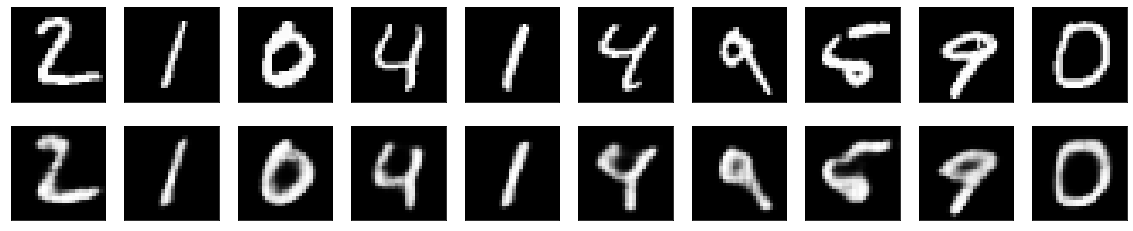

In [72]:
import matplotlib.pyplot as plt

decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig("final_compare.png")

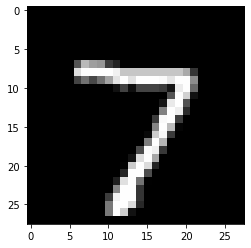

In [68]:
plt.imshow(x_test[0].reshape(28, 28))

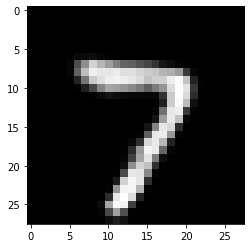

In [69]:
plt.imshow(decoded_imgs[0].reshape(28, 28))

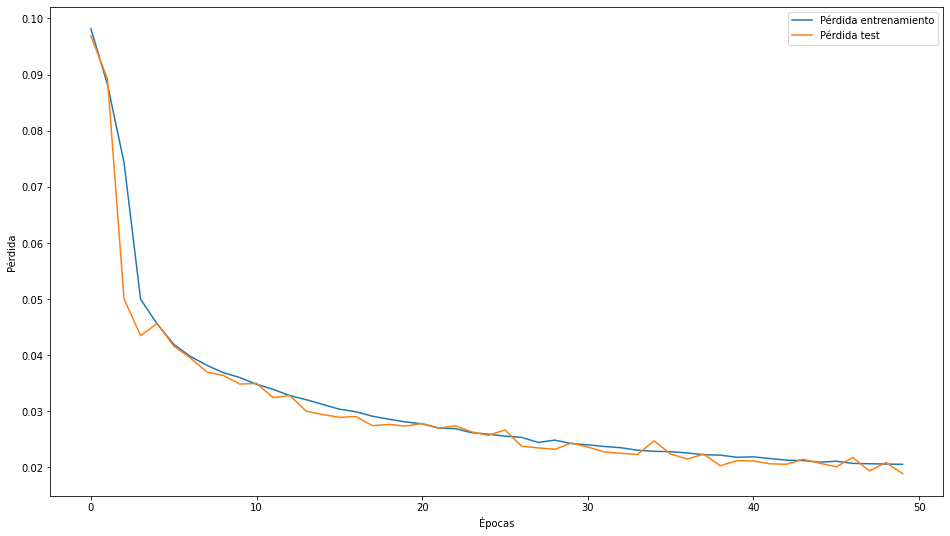

In [73]:
plt.figure(figsize=(16,9))
plt.plot(history.history["loss"], label="Pérdida entrenamiento")
plt.plot(history.history["val_loss"], label="Pérdida test")
plt.legend()
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.savefig("final_loss.png")

## Cargamos el modelo anterior

In [83]:
class Autoencoder:
    model = Sequential()
    def __init__(self, enc_dim=64, dropout=0.1, act_first="relu", act_second="sigmoid"):
        """ Initialize model."""
        self.enc_dim = enc_dim
        self.model.add(layers.Dropout(dropout, input_shape=(784,)))
        # Usamos RELU como función de activación para este caso.
        self.model.add(layers.Dense(enc_dim, activation=act_first))
        # Capa de "decodificacion", recibe 784, usamos activación sigmoide.
        self.model.add(layers.Dense(784, activation=act_second))

    def prepare_data(self):
        """Get data from MNIST and normalize."""
        (x_train, _), (x_test, _) = mnist.load_data()
        # Tenemos que normalizar para lograr mejores resultados, vamos a llevar todo desde los valores [0,255] a [0, 1]
        x_train = x_train.astype("float32") / np.amax(x_train) 
        x_test = x_test.astype("float32") / np.amax(x_test)

        # Tenemos que hacer nuestro input chato, las imágenes de MNIST vienen como matrices 28x28
        self.x_train = x_train.reshape((x_train.shape[0], np.prod(x_train.shape[1:])))
        self.x_test = x_test.reshape((x_test.shape[0], np.prod(x_test.shape[1:])))

    def train_model(self, learning_rate=1.0, momentum=0.5, nesterov=True, epochs=100, validate=True):
        sgd = SGD(nesterov=nesterov, momentum=momentum, learning_rate=learning_rate)
        self.model.compile(optimizer=sgd, loss="mean_squared_error")
        val_data = None
        if validate:
            val_data = (self.x_test, self.x_test)
        
        start = time.time()
        self.history = self.model.fit(
            self.x_train, self.x_train,
            epochs=epochs,
            verbose=0,
            shuffle=True,
            batch_size=1000,
            validation_data=val_data,
        )
        end = time.time()
        print(f"Entrenamiento {self.enc_dim} Neuronas: {end - start} segundos.")
        print(f"Pérdida en última época en entrenamiento: {self.history.history['loss'][-1]}")
        if validate:
            print(f"Pérdida en última época de validación: {self.history.history['val_loss'][-1]}")


Entrenamiento 512 Neuronas: 6.512436866760254 segundos.
Pérdida en última época en entrenamiento: 0.0258815735578537


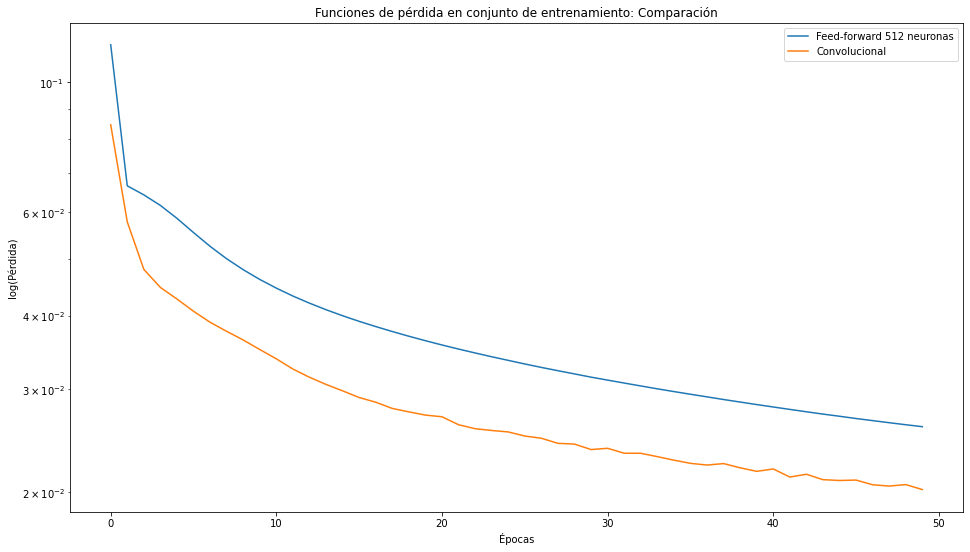

In [85]:
plt.figure(figsize=(16,9))
for dim in [512]:
    autoenc = Autoencoder(enc_dim=dim)
    autoenc.prepare_data()
    autoenc.train_model(epochs=50, validate=False)
    
    plt.semilogy(autoenc.history.history["loss"], label=f"Feed-forward {dim} neuronas")

plt.plot(history.history["loss"], label="Convolucional")

plt.title("Funciones de pérdida en conjunto de entrenamiento: Comparación")
plt.xlabel("Épocas")
plt.ylabel("log(Pérdida)")
plt.legend()
plt.savefig("final_train_loss.png")

Entrenamiento 512 Neuronas: 10.323229551315308 segundos.
Pérdida en última época en entrenamiento: 0.028537215664982796
Pérdida en última época de validación: 0.02600313350558281


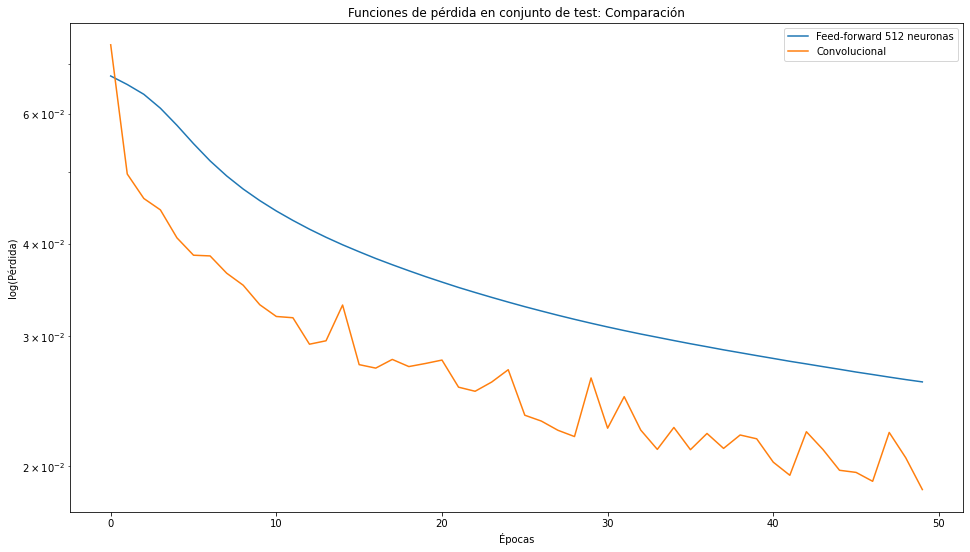

In [86]:
plt.figure(figsize=(16,9))
for dim in [512]:
    autoenc = Autoencoder(enc_dim=dim)
    autoenc.prepare_data()
    autoenc.train_model(epochs=50, validate=True)
    
    plt.semilogy(autoenc.history.history["val_loss"], label=f"Feed-forward {dim} neuronas")

plt.plot(history.history["val_loss"], label="Convolucional")

plt.title("Funciones de pérdida en conjunto de test: Comparación")
plt.xlabel("Épocas")
plt.ylabel("log(Pérdida)")
plt.legend()
plt.savefig("final_test_loss.png")